# Ensembles Historical Variables from LOCA and BCSD

This notebook analyzes meteorologic and hydrologic variables from the historical scenario (1950-2005) from the LOCA and BCSD datasets. 

Variables include:
- Precipitation
- Temperature
- ET
- Total Runoff

In [1]:
from loca import print_date
print_date()

Last executed: 2019-05-04 22:12:00.416714 by jvano on r6i6n30


# Imports and Options

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import xarray as xr

from loca.data_catalog import load_monthly_historical_met_datasets, load_daily_livneh_meteorology, resample_monthly_data
from loca.utils import calc_change

# models = ['ACCESS1-0', 'CanESM2'] 
# models = ['ACCESS1-0', 'CanESM2','MIROC5', 'MRI-CGCM3']

# list of 20, without issues
# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4', 'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G']

# list of 25, without issues:
models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4',
          'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
          'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
          'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']

all_vars = ['pcp', 't_mean', 't_min', 't_max', 'ET', 'total_runoff']
met_vars = ['pcp', 't_mean']

read_cache = True

In [3]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://10.148.10.13:34804 Dashboard: proxy/8787/status,Cluster Workers: 72 Cores: 288 Memory: 360.00 GB


# Load Data

In [4]:
hist_cmip_met_data = {}
if read_cache:
    print("reading values from cache")
    for key in ['loca', 'bcsd']:
        hist_cmip_met_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_met_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
    print("finished reading from cache for met")
    ds = hist_cmip_met_data['loca']
    print(ds['pcp'])

else:
    print("reading values from files directly")
    met_data = load_monthly_historical_met_datasets(models=models, autoclose=True, parallel=True)

reading values from cache
finished reading from cache for met
<xarray.DataArray 'pcp' (gcm: 25, time: 672, lat: 224, lon: 464)>
dask.array<shape=(25, 672, 224, 464), dtype=float64, chunksize=(1, 72, 224, 464)>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2005-12-01
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * gcm      (gcm) <U14 'ACCESS1-0' 'CCSM4' ... 'bcc-csm1-1' 'inmcm4'


In [5]:
hist_cmip_hydro_data = {}
if read_cache:
    print("reading values from cache")
    for key in ['loca', 'bcsd']:
        hist_cmip_hydro_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
    print("finished reading from cache")
    ds = hist_cmip_hydro_data['loca']
    print(ds['total_runoff'])
else:
    print("reading values from files directly")
    hydro_data = load_monthly_historical_hydro_datasets(models=models, autoclose=True, parallel=True)
    

reading values from cache
finished reading from cache
<xarray.DataArray 'total_runoff' (gcm: 25, time: 672, lat: 224, lon: 464)>
dask.array<shape=(25, 672, 224, 464), dtype=float32, chunksize=(1, 72, 224, 464)>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2005-12-01
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
  * gcm      (gcm) <U14 'ACCESS1-0' 'CCSM4' ... 'bcc-csm1-1' 'inmcm4'


In [6]:
# TODO trying to merge data without overwritting.  below doesn't do it correctly.

# all_loca = hist_cmip_hydro_data['loca']
# all_loca.update(hist_cmip_met_data['loca'])
# #all_loca.keys()

# all_bcsd = hist_cmip_hydro_data['bcsd']
# all_bcsd.update(hist_cmip_met_data['bcsd'])
# all_bcsd.keys()

# all_data = {**all_bcsd, **all_loca}
# print(all_data)

# #all_data = dict(hist_cmip_hydro_data.items() + hist_cmip_met_data.items())
# all_data = hist_cmip_hydro_data
# all_data['bcsd'].append

In [7]:
# merging, if do below, doesn't work because the last on the list overwrites 
# the first since they have the same keys

# all_data = {**hist_cmip_hydro_data, **hist_cmip_met_data}
# list(all_data.keys())

# # print(all_data['total_runoff'])
# # print(hist_cmip_met_data)
# # list(hist_cmip_met_data.keys())
# all_data['bcsd'].index

# met_data = {**hist_cmip_met_data}

# merging
# met_data = {**obs_data, **hist_cmip_met_data}
met_data = hist_cmip_met_data

In [8]:
epoch = slice('1969-10-01', '1999-09-30') # Julie updated to be water year

mask = met_data['bcsd']['t_mean'].isel(gcm=0, time=0).squeeze().notnull()

epoch_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS',
                                             chunks={'lat': 100, 'lon': 100}).mean('time').where(mask).persist()) for (k, ds) in met_data.items())

print("finished calculating epoch means")
ens_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', 
                                           chunks={'lat': 100, 'lon': 100}).mean('time').mean('gcm').where(mask).persist()) for (k, ds) in hist_cmip_met_data.items())
print("finished calculating ens means")

#TODO  merge before so don't have two separae files

# for debugging
# epoch_means = {}
# for k, ds in met_data.items():
#     print(k, flush=True)
#     epoch_means[k] = ds.sel(time=epoch).mean('time').where(mask).compute()

finished calculating epoch means
finished calculating ens means


In [9]:
epoch_means_hydro = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS',
                                             chunks={'lat': 100, 'lon': 100}).mean('time').where(mask).persist()) for (k, ds) in hist_cmip_hydro_data.items())
ens_means_hydro = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', 
                                           chunks={'lat': 100, 'lon': 100}).mean('time').mean('gcm').where(mask).persist()) for (k, ds) in hist_cmip_hydro_data.items())

# Plots

A single plot of both met and hydro data

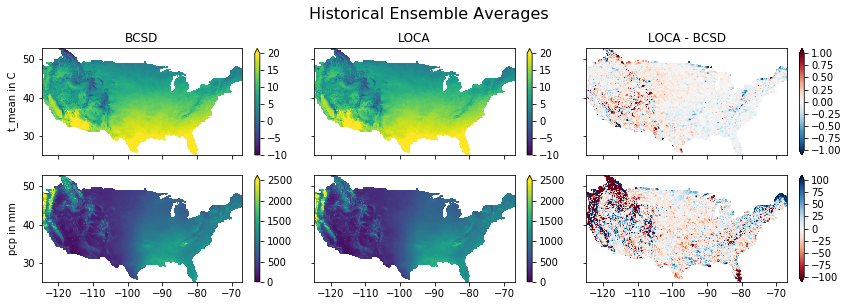

In [10]:
# TODO: merge datasets so can plot with single figure
# Fig Ja

kwargs = {'pcp': {'vmin': 0, 'vmax': 2500},
          't_mean': {'vmin': -10, 'vmax': 20},}
units = {'pcp': 'mm', 't_mean': 'C'}
pct = False
diff_kws = {False: {'pcp': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}},
            True: {'pcp': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu'}}}

met_vars = ['t_mean', 'pcp']

nrows = len(met_vars)
ncols = 3

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))


for row, var in enumerate(met_vars):
        
    for col, (title, ensemble) in enumerate([('BCSD', ens_means['bcsd'],),
                                             ('LOCA', ens_means['loca'])]):
        
        ax = axes[row, col]
        if row == 0:
            ax.set_title(title)
        
        ensemble[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        if col == 0:
            ax.set_ylabel(f'{met_vars[row]} in {units[var]}')
            
            
    ax = axes[row, -1]
    
    calc_change(ens_means['bcsd'][var], ens_means['loca'][var], pct=pct).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
    if row == 0:
        ax.set_title('LOCA - BCSD')  

    #diff = calc_change(ens_means['bcsd'][var], ens_means['loca'][var], pct=pct).persist()

                
    #title = var.upper()
    #title += ' (%s)' % units[var]
    unit_str = units[var]
    
fig.suptitle('Historical Ensemble Averages', fontsize=16, y=1.05)
fig.tight_layout()     
fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/met_monthly_historic_met_ens_avg_30WYs.png', dpi=300, bbox_inches='tight')

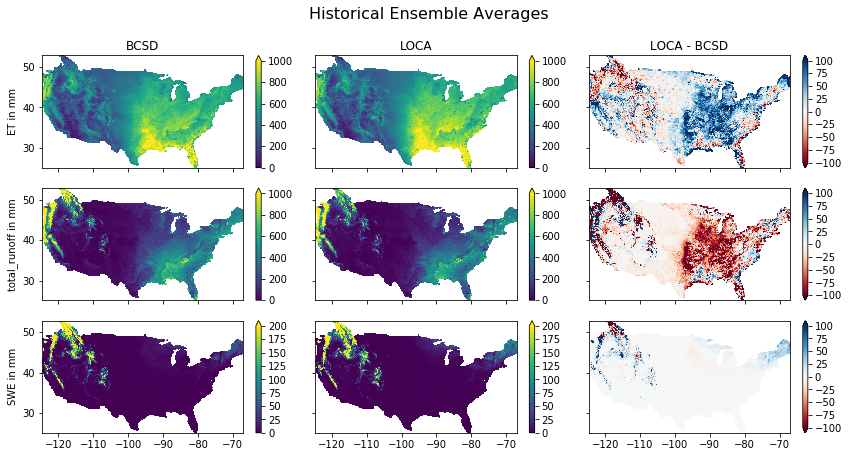

In [11]:
# Fig Jb
hydro_vars = ['ET', 'total_runoff', 'SWE']
kwargs = {'ET': {'vmin': 0, 'vmax': 1000},
          'total_runoff': {'vmin': 0, 'vmax': 1000},
          'SWE': {'vmin': 0, 'vmax': 200},}
units = {'ET': 'mm', 'total_runoff': 'mm', 'SWE': 'mm'}

pct = False
diff_kws = {False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}, 
                    'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                    'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}},
            True: {'ET': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}, 
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}}


nrows = len(hydro_vars)
ncols = 3

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 2*nrows))

for row, var in enumerate(hydro_vars):
        
    for col, (title, ensemble) in enumerate([('BCSD', ens_means_hydro['bcsd'],),
                                             ('LOCA', ens_means_hydro['loca'])]):
        
        ax = axes[row, col]
        if row == 0:
            ax.set_title(title)
        
        ensemble[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        if col == 0:
            ax.set_ylabel(f'{hydro_vars[row]} in {units[var]}')
            
            
    ax = axes[row, -1]
    
    calc_change(ens_means_hydro['bcsd'][var], ens_means_hydro['loca'][var], pct=pct).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
    if row == 0:
        ax.set_title('LOCA - BCSD')  
                
    #title = var.upper()
    #title += ' (%s)' % units[var]
    unit_str = units[var]
    
fig.suptitle('Historical Ensemble Averages', fontsize=16, y=1.05)
fig.tight_layout()     
fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/hydro_monthly_historic_met_ens_avg_30WYs.png', dpi=300, bbox_inches='tight')

In [ ]:
# cleanup 
plt.close('all')